In [3]:
import os
import numpy as np
from glob import glob
from PIL import Image,ImageEnhance
from tqdm import tqdm
import torch
import random
from torch.utils.data import Dataset, DataLoader, random_split,Subset
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR,CosineAnnealingLR,SequentialLR,LinearLR
from sklearn.metrics import roc_auc_score, accuracy_score
from torchvision import models
from torchvision.models import (
    EfficientNet_B0_Weights,
    EfficientNet_B1_Weights,
    EfficientNet_B2_Weights,
    EfficientNet_B3_Weights,
    EfficientNet_B4_Weights)
from torch.nn.functional import sigmoid
import cv2

In [100]:
SEED = 42


random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
def compute_mean_std(root_dir):
    exts = ("*.png",)
    sum_   = np.zeros(3, dtype=np.float64)
    sum_sq = np.zeros(3, dtype=np.float64)
    cnt    = 0

    files = []
    for split in ("train", "test"):
        for cls in ("normal","cataract"):
            for ext in exts:
                files += glob(os.path.join(root_dir, "processed_images", split, cls, ext))

    for f in tqdm(files, desc="Computing mean/std"):
        img = np.array(Image.open(f).convert("RGB")) / 255.0
        sum_   += img.mean(axis=(0,1))
        sum_sq += (img**2).mean(axis=(0,1))
        cnt    += 1

    mean = sum_ / cnt
    var  = (sum_sq / cnt) - mean**2
    std  = np.sqrt(var)
    return mean.tolist(), std.tolist()

In [99]:
_MEAN, _STD=[0.6257231324993875, 0.4934742948338769, 0.42569583700621416],[0.25667137400692847, 0.2345312511218496, 0.2305881956020596]

In [ ]:
# def clahe_gamma_pil(img, clip_limit=2.0, tile_size=(8,8), gamma=1.2):
#     arr = np.array(img)
#     lab = cv2.cvtColor(arr, cv2.COLOR_RGB2LAB)
#     l, a, b = cv2.split(lab)
#     clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_size)
#     l2 = clahe.apply(l)
#     lab2 = cv2.merge((l2,a,b))
#     rgb2 = cv2.cvtColor(lab2, cv2.COLOR_LAB2RGB)
#     pil2 = Image.fromarray(rgb2)
#     invGamma = 1.0 / gamma
#     table = [((i/255.0)**invGamma)*255 for i in range(256)]
#     return pil2.point(table*3)


# clean_transforms = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
# ])

# def make_train_transforms_iter2(is_cataract: bool):
#     base = [
#         clean_transforms,
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomRotation(10),
#     ]
#     if is_cataract:
#         base.append(transforms.Lambda(lambda img: clahe_gamma_pil(img, clip_limit=1.0, gamma=1.1)))  
#     base += [
#         transforms.ColorJitter(0.1,0.1,0.0,0.0),
#         transforms.RandomAdjustSharpness(0.7),
#         transforms.ToTensor(),
#         transforms.Normalize(_MEAN, _STD),
#     ]
#     return transforms.Compose(base)


# val_transforms = transforms.Compose([
#     clean_transforms,
#     transforms.ToTensor(),
#     transforms.Normalize(_MEAN, _STD)
# ])

In [36]:
# from torch.utils.data import DataLoader, Subset, random_split
# from torchvision.datasets import ImageFolder

# class ClassSpecificDataset(ImageFolder):
    
#     def __init__(self, root, split, base_transform, val_transform):
#         super().__init__(f"{root}/{split}")
#         self.base_transform = base_transform
#         self.val_transform  = val_transform

#     def __getitem__(self, idx):
#         path, label = self.samples[idx]
#         img = Image.open(path).convert("RGB")
        
#         if self.val_transform is not None:
#             tfm = self.val_transform
#         else:
#             tfm = make_train_transforms_iter2(is_cataract=(label==1))
#         img = tfm(img)
#         return img, label

# def get_dataloaders_iter2(root, batch_size=32, val_frac=0.2, num_workers=2):
#     full = ClassSpecificDataset(root, "train", base_transform=None, val_transform=None)
#     n = len(full)
#     val_size = int(n * val_frac)
#     train_size = n - val_size
#     train_idx, val_idx = random_split(list(range(n)), [train_size, val_size])

    
#     train_ds = Subset(full, train_idx)
#     val_ds   = Subset(
#         ClassSpecificDataset(root, "train", base_transform=None, val_transform=val_transforms),
#         val_idx
#     )
#     test_ds  = ClassSpecificDataset(root, "test", base_transform=None, val_transform=val_transforms)

    
#     return (
#       DataLoader(train_ds, batch_size, shuffle=True, 
#                  num_workers=num_workers, pin_memory=True),
#       DataLoader(val_ds,   batch_size, shuffle=False, 
#                  num_workers=num_workers, pin_memory=True),
#       DataLoader(test_ds,  batch_size, shuffle=False, 
#                  num_workers=num_workers, pin_memory=True),
#     )

In [113]:
class ImageDataset(Dataset):
    def __init__(self, dir, split="train", transform=None):
        self.transform = transform
        self.samples = []
        split_dir = os.path.join(dir, "processed_images", split)
        for label_name, label_idx in [("normal", 0), ("cataract", 1)]:
            for img_path in glob(os.path.join(split_dir, label_name, "*.png")):
                self.samples.append((img_path, label_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.float32)

In [ ]:
def get_dataloaders(
    root,
    batch_size=32,
    val_frac=0.2,
    num_workers=2,
    train_transform=None,
    val_transform=None
):

    raw_ds = ImageDataset(root, "train", transform=None)
    n = len(raw_ds)
    val_size = int(n * val_frac)
    train_size = n - val_size

    all_indices = list(range(n))
    train_indices, val_indices = random_split(all_indices, [train_size, val_size])

    train_ds = Subset(
        ImageDataset(root, "train", transform=train_transform),
        train_indices
    )
    val_ds = Subset(
        ImageDataset(root, "train", transform=val_transform),
        val_indices
    )
    test_ds = ImageDataset(root, "test", transform=val_transform)

    return (
        DataLoader(train_ds, batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True),
        DataLoader(val_ds,   batch_size, shuffle=False, num_workers=num_workers, pin_memory=True),
        DataLoader(test_ds,  batch_size, shuffle=False, num_workers=num_workers, pin_memory=True),
    )

In [93]:
def build_model(backbone="resnet50", pretrained=True):
    if backbone.startswith("resnet"):
        model = getattr(models, backbone)(pretrained=pretrained)
        in_feats = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(in_feats, 1)
        
        )

    elif backbone.startswith("efficientnet"):
        if pretrained:
            weights_map = {
                "efficientnet_b0": EfficientNet_B0_Weights.DEFAULT,
                "efficientnet_b1": EfficientNet_B1_Weights.DEFAULT,
                "efficientnet_b2": EfficientNet_B2_Weights.DEFAULT,
                "efficientnet_b3": EfficientNet_B3_Weights.DEFAULT,
                "efficientnet_b4": EfficientNet_B4_Weights.DEFAULT
            }
            weights = weights_map.get(backbone, None)
            if weights is None:
                raise ValueError(f"Pretrained weights not available for {backbone}")
            model = getattr(models, backbone)(weights=weights)
        else:
            model = getattr(models, backbone)(weights=None)

        in_feats = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(in_feats, 1)
        
        )

    else:
        raise ValueError(f"Unsupported backbone: {backbone}")

    return model

In [94]:
def train_single_epoch(model, train_loader, optimizer, scheduler, loss_fn, device):
    model.train()
    t_loss, preds, lbl = 0, [], []

    for imgs, labs in tqdm(train_loader, desc="Training", leave=False):
        imgs, labs = imgs.to(device), labs.to(device).unsqueeze(1).float()

        optimizer.zero_grad()
        logits = model(imgs)
        loss = loss_fn(logits, labs)
        loss.backward()
        optimizer.step()
        scheduler.step()


        probs = torch.sigmoid(logits.detach().cpu())
        labs_cpu = labs.detach().cpu()

        if probs.ndim > 1:
            probs = probs.squeeze(1)
        if labs_cpu.ndim > 1:
            labs_cpu = labs_cpu.squeeze(1)

        preds += probs.tolist()
        lbl += labs_cpu.tolist()
        t_loss += loss.item() * imgs.size(0)

    avg_loss = t_loss / len(train_loader.dataset)
    auc = roc_auc_score(lbl, preds)
    acc = accuracy_score(lbl, [p > 0.5 for p in preds])
    return avg_loss, auc, acc

In [95]:
def eval_one_epoch(model, loader, loss_fn, device):
    model.eval()
    preds, lbl = [], []
    total_loss = 0.0

    with torch.no_grad():
        for imgs, labs in loader:
            imgs, labs = imgs.to(device), labs.to(device).unsqueeze(1).float()

            logits = model(imgs)
            loss = loss_fn(logits, labs)
            total_loss += loss.item() * imgs.size(0)

            probs = torch.sigmoid(logits.detach().cpu())
            labs_cpu = labs.detach().cpu()
            if probs.ndim > 1:   probs = probs.squeeze(1)
            if labs_cpu.ndim > 1: labs_cpu = labs_cpu.squeeze(1)

            preds += probs.tolist()
            lbl   += labs_cpu.tolist()

    avg_loss = total_loss / len(loader.dataset)
    auc      = roc_auc_score(lbl, preds)
    acc      = accuracy_score(lbl, [p>0.5 for p in preds])
    return avg_loss, auc, acc, preds, lbl

In [96]:
clean_transforms_iter1 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
])

train_transforms_iter1 = transforms.Compose([
    transforms.Resize(400),
    transforms.CenterCrop(380),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.1, 0.1),
    transforms.RandomAdjustSharpness(0.7),
    transforms.ToTensor(),
    transforms.Normalize(_MEAN, _STD)
])

val_transforms_iter1 = transforms.Compose([
    transforms.Resize(400),
    transforms.CenterCrop(380),
    transforms.ToTensor(),
    transforms.Normalize(_MEAN, _STD)
])

In [ ]:
DATA_ROOT = "./data/raw/cataract-image-dataset/processed_images"
BATCH_SIZE   = 32
VAL_FRAC     = 0.2

BACKBONE     = "efficientnet_b4"     # "resnet_50"
PRETRAINED   = True
LR           = 1e-4
WEIGHT_DECAY = 1e-4
EPOCHS       = 10

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


In [115]:
train_loader_iter1, val_loader_iter1, test_loader_iter1 = get_dataloaders(
    root=DATA_ROOT,
    batch_size=8,
    val_frac=0.2,
    num_workers=2,
    train_transform=train_transforms_iter1,
    val_transform=val_transforms_iter1
)

491 ---- <torch.utils.data.dataset.Subset object at 0x792017d88b10> ... <torch.utils.data.dataset.Subset object at 0x792017d88590>


In [116]:
model_iter1 = build_model(backbone="efficientnet_b4", pretrained=True).to(DEVICE)

for param in model_iter1.features[:3].parameters():
    param.requires_grad = False

In [117]:
bce_loss_iter1=nn.BCEWithLogitsLoss()

opt_iter1 = AdamW(model_iter1.parameters(), lr=1e-4, weight_decay=1e-4)

warmup_epochs_iter1 = 2

scheduler_iter1 = SequentialLR(
    opt_iter1,
    schedulers=[
        LinearLR(opt_iter1, start_factor=0.1, total_iters=warmup_epochs_iter1),
        CosineAnnealingLR(opt_iter1, T_max=EPOCHS - warmup_epochs_iter1)
    ],
    milestones=[warmup_epochs_iter1]
)

In [119]:
best_val_auc_iter1 = 0.0
history_iter1 = {
    'train_loss': [],
    'val_loss': [],
    'train_auc': [],
    'val_auc': [],
    'train_acc': [],
    'val_acc': []
}

for epoch in range(1, EPOCHS + 1):

    train_loss, train_auc, train_acc = train_single_epoch(
        model_iter1, train_loader_iter1,
        opt_iter1, scheduler_iter1,
        bce_loss_iter1, DEVICE
    )

 
    val_loss, val_auc, val_acc, val_preds, val_labels = eval_one_epoch(
        model_iter1, val_loader_iter1,
        bce_loss_iter1, DEVICE
    )


    history_iter1['train_loss'].append(train_loss)
    history_iter1['val_loss'].append(val_loss)
    history_iter1['train_auc'].append(train_auc)
    history_iter1['val_auc'].append(val_auc)
    history_iter1['train_acc'].append(train_acc)
    history_iter1['val_acc'].append(val_acc)


    print(f"Epoch {epoch}/{EPOCHS}  "
          f"Train L:{train_loss:.4f} AUC:{train_auc:.4f} Acc:{train_acc:.4f} | "
          f"Val   L:{val_loss:.4f} AUC:{val_auc:.4f} Acc:{val_acc:.4f}")


    if val_auc > best_val_auc_iter1:
        best_val_auc_iter1 = val_auc
        torch.save(model_iter1.state_dict(), "best_model_effnet.pth")

Epoch 1/10  Train L:0.2141 AUC:0.9809 Acc:0.9338 | Val   L:0.1517 AUC:0.9899 Acc:0.9388


Epoch 2/10  Train L:0.1591 AUC:0.9882 Acc:0.9491 | Val   L:0.1273 AUC:0.9912 Acc:0.9388


Epoch 3/10  Train L:0.1237 AUC:0.9933 Acc:0.9542 | Val   L:0.1540 AUC:0.9916 Acc:0.9490


Epoch 4/10  Train L:0.1197 AUC:0.9921 Acc:0.9618 | Val   L:0.1638 AUC:0.9907 Acc:0.9490


Epoch 5/10  Train L:0.1063 AUC:0.9940 Acc:0.9593 | Val   L:0.1084 AUC:0.9920 Acc:0.9592


Epoch 6/10  Train L:0.0960 AUC:0.9939 Acc:0.9771 | Val   L:0.1099 AUC:0.9945 Acc:0.9592


Epoch 7/10  Train L:0.0634 AUC:0.9981 Acc:0.9822 | Val   L:0.1405 AUC:0.9937 Acc:0.9490


Epoch 8/10  Train L:0.0621 AUC:0.9985 Acc:0.9771 | Val   L:0.1561 AUC:0.9937 Acc:0.9490


Epoch 9/10  Train L:0.0641 AUC:0.9980 Acc:0.9771 | Val   L:0.1408 AUC:0.9941 Acc:0.9490


Epoch 10/10  Train L:0.0427 AUC:0.9987 Acc:0.9898 | Val   L:0.1487 AUC:0.9941 Acc:0.9490


In [ ]:
model.load_state_dict(torch.load("best_model_effnet.pth"))
model.eval()


test_loss, test_auc, test_acc, test_preds, test_labels = eval_one_epoch(
    model, test_loader, loss_fn, DEVICE
)
print(f"\n Final Test — Loss: {test_loss:.4f} | AUC: {test_auc:.4f} | Accuracy: {test_acc:.4f}")

**Iteration 3a- Apply Augmentation to both Normal + Cataract images**

In [44]:
train_transforms_3a = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),

    
    transforms.Lambda(lambda img: clahe_gamma_pil(
        img, clip_limit=1.0, tile_size=(8,8), gamma=1.1
    )),

    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.1, 0.1),
    transforms.RandomAdjustSharpness(0.7),

    transforms.ToTensor(),
    transforms.Normalize(_MEAN, _STD),
])

val_transforms_3a = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(_MEAN, _STD),
])

In [45]:
from torch.utils.data import DataLoader, Subset, random_split
from torchvision.datasets import ImageFolder

def get_dataloaders_3a(
    root,
    batch_size=32,
    val_frac=0.2,
    num_workers=2,
    train_transform=None,
    val_transform=None
):
    
    full_ds = ImageFolder(f"{root}/train", transform=None)
    n = len(full_ds)
    val_size = int(n * val_frac)
    train_size = n - val_size

    
    train_idx, val_idx = random_split(
        list(range(n)),
        [train_size, val_size]
    )


    train_subset = Subset(
        ImageFolder(f"{root}/train", transform=train_transform),
        train_idx
    )
    val_subset = Subset(
        ImageFolder(f"{root}/train", transform=val_transform),
        val_idx
    )

  
    test_ds = ImageFolder(f"{root}/test", transform=val_transform)

    
    train_loader = DataLoader(
        train_subset, batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True
    )
    val_loader = DataLoader(
        val_subset, batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True
    )
    test_loader = DataLoader(
        test_ds, batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True
    )

    return train_loader, val_loader, test_loader

In [46]:
model_3a     = build_model("resnet50", pretrained=True).to(DEVICE)
loss_fn_3a   = nn.BCEWithLogitsLoss()
opt_3a       = AdamW(model_3a.parameters(), lr=5e-4, weight_decay=1e-4)
schd_3a      = SequentialLR(
    opt_3a,
    schedulers=[
        LinearLR(opt_3a, start_factor=0.1, total_iters=2),
        CosineAnnealingLR(opt_3a, T_max=EPOCHS-2)
    ],
    milestones=[2]
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [48]:
train_loader_3a, val_loader_3a, test_loader_3a = get_dataloaders_3a(
    root=DATA_ROOT,
    batch_size=32,
    val_frac=0.2,
    num_workers=2,
    train_transform=train_transforms_3a,
    val_transform=val_transforms_3a
)

In [49]:
best_val_auc_3a = 0.0
history_3a = {k:[] for k in ['train_loss','val_loss','train_auc','val_auc','train_acc','val_acc']}

for epoch in range(1, EPOCHS+1):
    tl, ta, tc = train_single_epoch(
        model_3a, train_loader_3a, opt_3a, schd_3a, loss_fn_3a, DEVICE
    )
    vl, va, vc, vp, vlbl = eval_one_epoch(
        model_3a, val_loader_3a, loss_fn_3a, DEVICE
    )

    # Record & print
    history_3a['train_loss'].append(tl)
    history_3a['val_loss'].append(vl)
    history_3a['train_auc'].append(ta)
    history_3a['val_auc'].append(va)
    history_3a['train_acc'].append(tc)
    history_3a['val_acc'].append(vc)

    print(
      f"3a Ep{epoch}: Train L{tl:.3f}/AUC{ta:.3f}/Acc{tc:.3f} | "
      f"Val L{vl:.3f}/AUC{va:.3f}/Acc{vc:.3f}"
    )

    if va > best_val_auc_3a:
        best_val_auc_3a = va
        torch.save(model_3a.state_dict(), "best_model_3a.pth")
        print(f" ↳ New best AUC: {best_val_auc_3a:.4f}")

Training:   8%|▊         | 1/13 [00:01<00:18,  1.53s/it]/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


3a Ep1: Train L0.306/AUC0.945/Acc0.855 | Val L0.311/AUC0.980/Acc0.959
 ↳ New best AUC: 0.9800


3a Ep2: Train L0.077/AUC0.996/Acc0.977 | Val L0.296/AUC0.991/Acc0.959
 ↳ New best AUC: 0.9908


3a Ep3: Train L0.124/AUC0.990/Acc0.952 | Val L0.850/AUC0.946/Acc0.827


3a Ep4: Train L0.052/AUC0.999/Acc0.992 | Val L0.432/AUC0.989/Acc0.898


3a Ep5: Train L0.043/AUC0.999/Acc0.990 | Val L0.224/AUC0.964/Acc0.969


3a Ep6: Train L0.045/AUC0.999/Acc0.987 | Val L0.294/AUC0.967/Acc0.949


3a Ep7: Train L0.038/AUC1.000/Acc0.987 | Val L0.287/AUC0.994/Acc0.929
 ↳ New best AUC: 0.9942


3a Ep8: Train L0.027/AUC1.000/Acc0.985 | Val L0.165/AUC0.984/Acc0.959


3a Ep9: Train L0.025/AUC1.000/Acc0.992 | Val L0.289/AUC0.987/Acc0.959


3a Ep10: Train L0.029/AUC0.999/Acc0.992 | Val L0.309/AUC0.965/Acc0.969


**Iteration 3b- PreProcess all images and then train**

In [50]:
import os, cv2, numpy as np
from PIL import Image

def preprocess_folder(src_dir, dst_dir, clip=1.0, tile=(8,8), gamma=1.1):
    os.makedirs(dst_dir, exist_ok=True)
    for fname in os.listdir(src_dir):
        if not fname.lower().endswith('.png'): continue
        img = Image.open(os.path.join(src_dir, fname)).convert('RGB')
        arr = np.array(img)
        lab = cv2.cvtColor(arr, cv2.COLOR_RGB2LAB)
        l,a,b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=tile)
        l2 = clahe.apply(l)
        merged = cv2.merge((l2,a,b))
        rgb2   = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)
        pil2   = Image.fromarray(rgb2)
      
        invG = 1.0 / gamma
        table = [((i/255.0)**invG)*255 for i in range(256)]
        out_img = pil2.point(table*3)
        out_img.save(os.path.join(dst_dir, fname))


RAW_ROOT  = DATA_ROOT
PROC_ROOT = "/kaggle/working/data_processed"

for split in ["train", "test"]:
    for cls in ["cataract", "normal"]:
        src = os.path.join(RAW_ROOT, split, cls)
        dst = os.path.join(PROC_ROOT, split, cls)
        preprocess_folder(src, dst, clip=1.0, tile=(8,8), gamma=1.1)

In [57]:
train_transforms_3b = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.1, 0.1),
    transforms.RandomAdjustSharpness(0.7),
    transforms.ToTensor(),
    transforms.Normalize(_MEAN, _STD),
])

# 2.B) Val/Test transforms (no randomness)
val_transforms_3b = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(_MEAN, _STD),
])

# 2.C) Build datasets & loaders from processed data
base_dataset = ImageFolder(os.path.join(PROC_ROOT, "train"))

# 2. Create deterministic split
n = len(base_dataset)
val_count = int(n * 0.2)
train_count = n - val_count
train_idx, val_idx = random_split(
    list(range(n)),
    [train_count, val_count],
    generator=torch.Generator().manual_seed(42)  # to keep splits reproducible
)

# 3. Apply correct transforms to each split via Subset + manual wrapping
train_ds_3b = Subset(ImageFolder(os.path.join(PROC_ROOT, "train"), transform=train_transforms_3b), train_idx)
val_ds_3b   = Subset(ImageFolder(os.path.join(PROC_ROOT, "train"), transform=val_transforms_3b), val_idx)
test_ds_3b  = ImageFolder(os.path.join(PROC_ROOT, "test"), transform=val_transforms_3b)

# 4. Dataloaders
train_loader_3b = DataLoader(train_ds_3b, batch_size=32, shuffle=True,  num_workers=2, pin_memory=True)
val_loader_3b   = DataLoader(val_ds_3b,   batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader_3b  = DataLoader(test_ds_3b,  batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


In [58]:
train_files = set([base_dataset.samples[i][0] for i in train_idx])
val_files   = set([base_dataset.samples[i][0] for i in val_idx])
print("Overlap:", len(train_files & val_files)) 

Overlap: 0


In [59]:
model_3b     = build_model("resnet50", pretrained=True).to(DEVICE)
loss_fn_3b   = nn.BCEWithLogitsLoss()
opt_3b       = AdamW(model_3b.parameters(), lr=5e-4, weight_decay=1e-4)
schd_3b      = SequentialLR(
    opt_3b,
    schedulers=[
        LinearLR(opt_3b, start_factor=0.1, total_iters=2),
        CosineAnnealingLR(opt_3b, T_max=EPOCHS-2)
    ],
    milestones=[2]
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [62]:
best_val_auc_3b = 0.0
history_3b = {k: [] for k in ['train_loss','val_loss','train_auc','val_auc','train_acc','val_acc']}

for epoch in range(1, EPOCHS + 1):
    # Train
    tl, ta, tc = train_single_epoch(
        model_3b, train_loader_3b, opt_3b, schd_3b, loss_fn_3b, DEVICE
    )
    # Validate
    vl, va, vc, vp, vlbl = eval_one_epoch(
        model_3b, val_loader_3b, loss_fn_3b, DEVICE
    )

    # Record
    history_3b['train_loss'].append(tl)
    history_3b['val_loss'].append(vl)
    history_3b['train_auc'].append(ta)
    history_3b['val_auc'].append(va)
    history_3b['train_acc'].append(tc)
    history_3b['val_acc'].append(vc)

    # Log
    print(
        f"3b Ep{epoch}: Train L{tl:.4f}/AUC{ta:.4f}/Acc{tc:.4f} | "
        f"Val L{vl:.4f}/AUC{va:.4f}/Acc{vc:.4f}"
    )

    # Checkpoint
    if va > best_val_auc_3b:
        best_val_auc_3b = va
        torch.save(model_3b.state_dict(), "best_model_3b.pth")
        print(f" ↳ New best AUC: {best_val_auc_3b:.4f}")

3b Ep1: Train L0.0165/AUC0.9999/Acc0.9975 | Val L0.2646/AUC0.9841/Acc0.9490
 ↳ New best AUC: 0.9841


3b Ep2: Train L0.0060/AUC1.0000/Acc1.0000 | Val L0.2590/AUC0.9816/Acc0.9490


3b Ep3: Train L0.0033/AUC1.0000/Acc1.0000 | Val L0.2483/AUC0.9748/Acc0.9286


3b Ep4: Train L0.0435/AUC0.9990/Acc0.9822 | Val L1.1815/AUC0.9354/Acc0.7959


3b Ep5: Train L0.1190/AUC0.9938/Acc0.9466 | Val L1.7589/AUC0.9059/Acc0.8776


3b Ep6: Train L0.0824/AUC0.9926/Acc0.9822 | Val L0.7344/AUC0.9300/Acc0.9286


3b Ep7: Train L0.0703/AUC0.9956/Acc0.9796 | Val L0.4496/AUC0.9627/Acc0.8776


3b Ep8: Train L0.1096/AUC0.9957/Acc0.9517 | Val L0.7675/AUC0.9694/Acc0.8367


3b Ep9: Train L0.0644/AUC0.9958/Acc0.9822 | Val L0.2168/AUC0.9786/Acc0.9388


3b Ep10: Train L0.0499/AUC0.9985/Acc0.9847 | Val L0.1875/AUC0.9849/Acc0.9286
 ↳ New best AUC: 0.9849


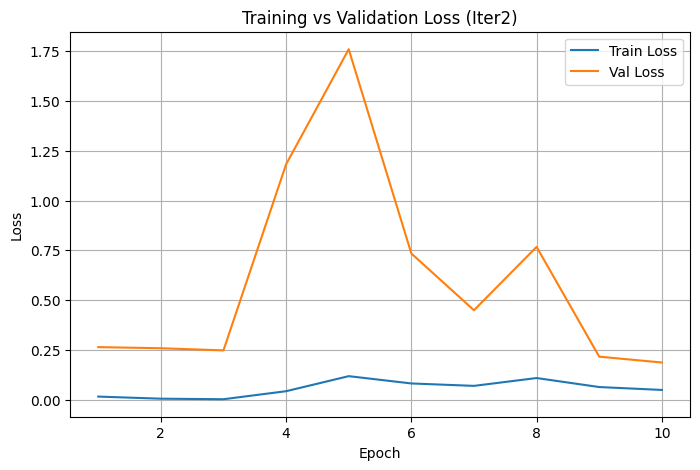

In [63]:
epochs = range(1, EPOCHS+1)
plt.figure(figsize=(8,5))
plt.plot(epochs, history_3b['train_loss'], label='Train Loss')
plt.plot(epochs, history_3b['val_loss'],   label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (Iter2)")
plt.legend()
plt.grid(True)
plt.show()